<a href="https://colab.research.google.com/github/teakrcmar/KPI-predictions/blob/main/prediction_ver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!git clone https://github.com/teakrcmar/KPI-predictions.git

fatal: destination path 'KPI-predictions' already exists and is not an empty directory.


In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Ensure no division by zero in calculated columns
df['CPA_leads'] = df['mark_spent'] / df['leads'].replace(0, np.nan)
df['CTR'] = (df['clicks'] / df['impressions'].replace(0, np.nan)) * 100
df['Conversion_Rate_Clicks_Leads'] = (df['leads'] / df['clicks'].replace(0, np.nan)) * 100
df['CPC'] = df['mark_spent'] / df['clicks'].replace(0, np.nan)
df['CPM'] = (df['mark_spent'] / df['impressions'].replace(0, np.nan)) * 1000
df['AOV'] = df['revenue'] / df['orders'].replace(0, np.nan)
df['RPC'] = df['revenue'] / df['clicks'].replace(0, np.nan)

# Encode 'campaign_name'
label_encoder = LabelEncoder()
df['campaign_name'] = label_encoder.fit_transform(df['campaign_name'])

# Select relevant features and target
features = ['campaign_name', 'impressions', 'mark_spent', 'clicks', 'leads', 'orders']
target = 'revenue'

# Scale the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_target = scaler.fit_transform(df[[target]])

# Combine features and target for sequence creation
scaled_data = np.hstack((scaled_features, scaled_target))

def create_sequences(data, seq_length=10):
    """
    Create input-output pairs for time-series forecasting.
    - data: Scaled dataset (numpy array)
    - seq_length: Number of time steps in each sequence
    """
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1])  # All but last column as features
        y.append(data[i, -1])  # Last column as target
    return np.array(X), np.array(y)

# Sequence length
seq_length = 10
X, y = create_sequences(scaled_data, seq_length=seq_length)

# Split indices for training, validation, and test sets
total_samples = len(X)
train_end = int(total_samples * 0.7)
val_end = int(total_samples * 0.9)

# Train, validation, and test splits
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# Define the model
model = Sequential([
    GRU(64, return_sequences=False, input_shape=(seq_length, X.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)  # Single output for revenue
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
from tensorflow.keras.optimizers import Adam

# Set Adam optimizer with a learning rate of 0.002
optimizer = Adam(learning_rate=0.002)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])


# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    verbose=1
)


# Save the trained model
model.save("gru_model_v3.h5")

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0240 - mae: 0.1042 - val_loss: 0.0044 - val_mae: 0.0585
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0123 - mae: 0.0686 - val_loss: 0.0027 - val_mae: 0.0310
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0130 - mae: 0.0531 - val_loss: 0.0020 - val_mae: 0.0231
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0090 - mae: 0.0555 - val_loss: 0.0027 - val_mae: 0.0410
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0103 - mae: 0.0652 - val_loss: 0.0020 - val_mae: 0.0285
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0104 - mae: 0.0543 - val_loss: 0.0019 - val_mae: 0.0232
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0129 - mae: 0.0559 - val_loss: 0.0021 - val_mae: 0.0298
Epoch 8/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0080 - mae: 0.0549 - val_loss: 0.0021 - val_mae: 0.0293
Epoch 9/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0093 - mae:

In [52]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Test Loss: 0.0002, Test MAE: 0.0128


In [53]:
# Make predictions on the testing data
y_test_pred = model.predict(X_test)

# Step 1: Prepare padding (dummy columns to match scaler dimensions)
# X_test shape: (samples, sequence_length, features). We need the last timestep's features.
padding = np.zeros((y_test_pred.shape[0], 1))  # Placeholder for one missing column

# Step 2: Combine last timestep features with predictions
# X_test[:, -1, :-1] extracts the last timestep's features except the target column
y_test_pred_combined = np.hstack((X_test[:, -1, :-1], y_test_pred, padding))

# Step 3: Reverse scale the predictions using the scaler
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred_combined)[:, -2]  # Extract the revenue column

# Step 4: Reverse scale the actual revenue values for comparison
y_test_actual_combined = np.hstack((X_test[:, -1, :-1], y_test.reshape(-1, 1), padding))
y_test_actual_rescaled = scaler.inverse_transform(y_test_actual_combined)[:, -2]

# Print the results
print("Rescaled Predicted Revenue (Test Set):", y_test_pred_rescaled)
print("Rescaled Actual Revenue (Test Set):", y_test_actual_rescaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Rescaled Predicted Revenue (Test Set): [ 12810.06465249 118144.24729317  32002.85775214   -629.39634614
   -807.92167582  48775.04477657 102618.88247043 102994.56204206
  86319.30193968  31968.71697001 -41887.22972997 -30979.33103882
  68170.7966274   -1474.18818071 -38552.63347872 -38334.83865343
  31722.83209197  74090.15445612  67576.86122254  43885.85112795
  13306.90549605  -6709.76644106   9124.90328558  83026.95078082
  16064.26216453 -21962.230272   -22027.76150472  39781.16728537
  80420.90949535  74912.4511981 ]
Rescaled Actual Revenue (Test Set): [  2283. 127696.  26556.   1981.   4981.      0.  25205.  12213.   4223.
      0.      0.      0.  23943.   5981.      0.      0.      0.   4661.
   3981.   4981.   5509.   8714.      0.  37450.   5981.      0.      0.
   1491.   5008.   7030.]


Comparison of Predicted vs Actual Revenue (First 10 Test Samples):
------------------------------------------------------------
Sample 1: Predicted Revenue = 12810.06, Actual Revenue = 2283.00
Sample 2: Predicted Revenue = 118144.25, Actual Revenue = 127696.00
Sample 3: Predicted Revenue = 32002.86, Actual Revenue = 26556.00
Sample 4: Predicted Revenue = -629.40, Actual Revenue = 1981.00
Sample 5: Predicted Revenue = -807.92, Actual Revenue = 4981.00
Sample 6: Predicted Revenue = 48775.04, Actual Revenue = 0.00
Sample 7: Predicted Revenue = 102618.88, Actual Revenue = 25205.00
Sample 8: Predicted Revenue = 102994.56, Actual Revenue = 12213.00
Sample 9: Predicted Revenue = 86319.30, Actual Revenue = 4223.00
Sample 10: Predicted Revenue = 31968.72, Actual Revenue = 0.00


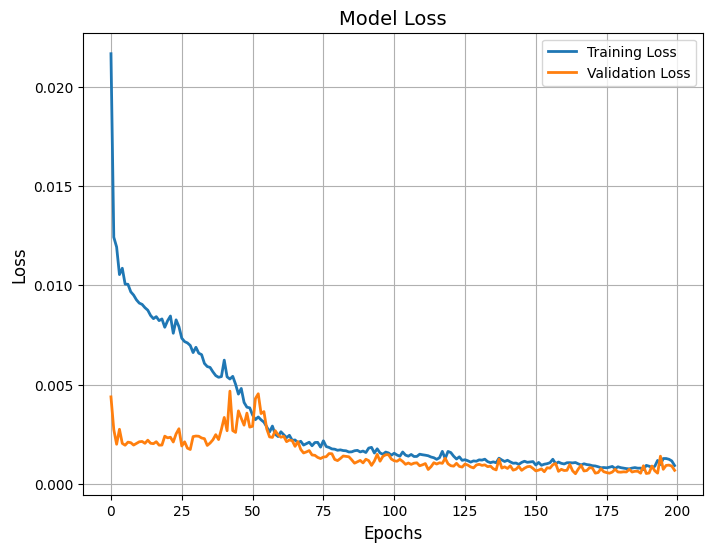

In [54]:
# Display the comparison for the first 10 samples
print("Comparison of Predicted vs Actual Revenue (First 10 Test Samples):")
print("-" * 60)

for i in range(10):  # First 10 samples
    print(f"Sample {i+1}: Predicted Revenue = {y_test_pred_rescaled[i]:.2f}, "
          f"Actual Revenue = {y_test_actual_rescaled[i]:.2f}")

# Plot the training and validation loss
plt.figure(figsize=(8, 6))  # Set figure size for better visuals
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)  # Add a grid for better readability
plt.show()


In [55]:
# Print a summary of the model
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                          │ (None, 64)                  │          13,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,813 (186.77 KB)

 Trainable params: 15,937 (62.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 31,876 (124.52 KB)